Epoch 1/50
27/27 [==============================] - 13s 408ms/step - loss: 0.6940 - accuracy: 0.7436 - val_loss: 0.3358 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 11s 389ms/step - loss: 0.3636 - accuracy: 0.8501 - val_loss: 0.3340 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 11s 400ms/step - loss: 0.3089 - accuracy: 0.8607 - val_loss: 0.3366 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 11s 409ms/step - loss: 0.2717 - accuracy: 0.8899 - val_loss: 0.3306 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 11s 405ms/step - loss: 0.2957 - accuracy: 0.8782 - val_loss: 0.3855 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 11s 404ms/step - loss: 0.2234 - accuracy: 0.9192 - val_loss: 0.3025 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 11s 403ms/st

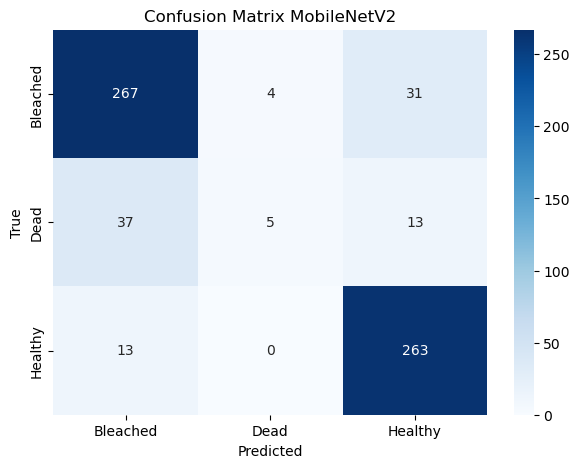

              precision    recall  f1-score   support

    Bleached       0.84      0.88      0.86       302
        Dead       0.56      0.09      0.16        55
     Healthy       0.86      0.95      0.90       276

    accuracy                           0.85       633
   macro avg       0.75      0.64      0.64       633
weighted avg       0.82      0.85      0.82       633



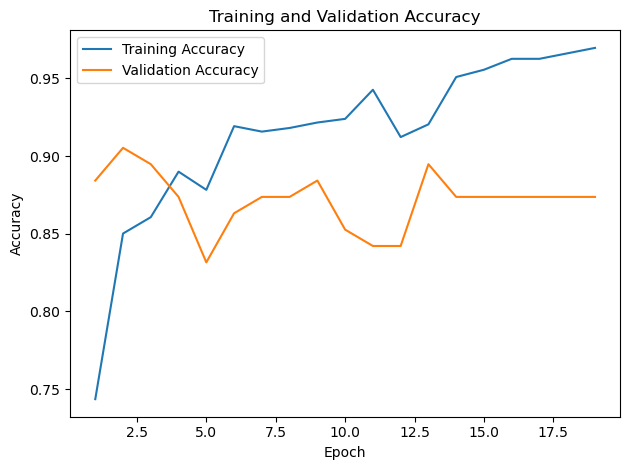

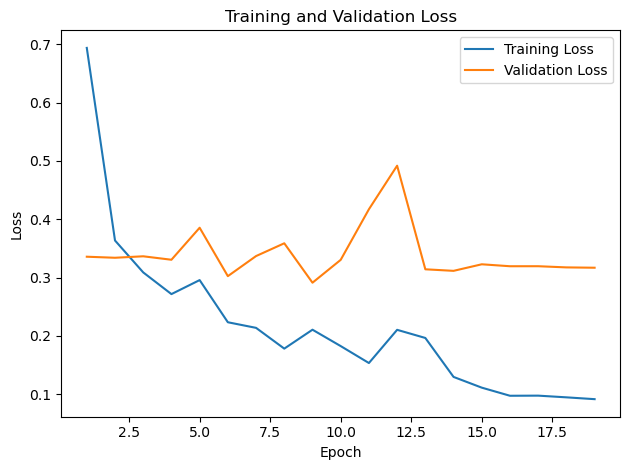

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224  # Adjust the image size based on MobileNetV2's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(Categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

Epoch 1/50
27/27 [==============================] - 41s 1s/step - loss: 0.7708 - accuracy: 0.6920 - val_loss: 0.2990 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 52s 2s/step - loss: 0.3640 - accuracy: 0.8466 - val_loss: 0.2762 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 51s 2s/step - loss: 0.3190 - accuracy: 0.8653 - val_loss: 0.2239 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 55s 2s/step - loss: 0.2402 - accuracy: 0.9028 - val_loss: 0.2320 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 54s 2s/step - loss: 0.3218 - accuracy: 0.8724 - val_loss: 0.2157 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 55s 2s/step - loss: 0.2931 - accuracy: 0.8735 - val_loss: 0.2493 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 55s 2s/step - loss: 0.2383 - a

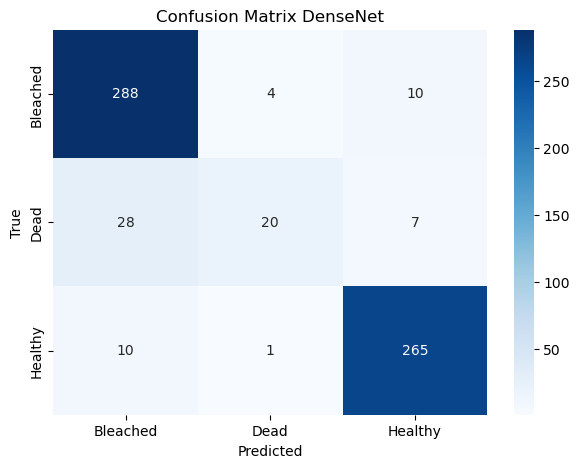

              precision    recall  f1-score   support

    Bleached       0.88      0.95      0.92       302
        Dead       0.80      0.36      0.50        55
     Healthy       0.94      0.96      0.95       276

    accuracy                           0.91       633
   macro avg       0.87      0.76      0.79       633
weighted avg       0.90      0.91      0.90       633



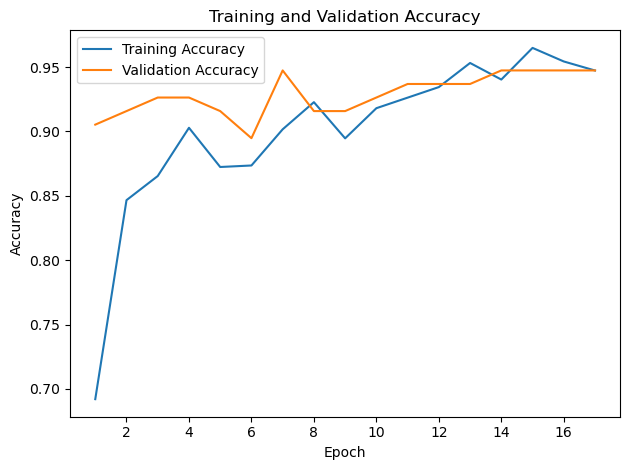

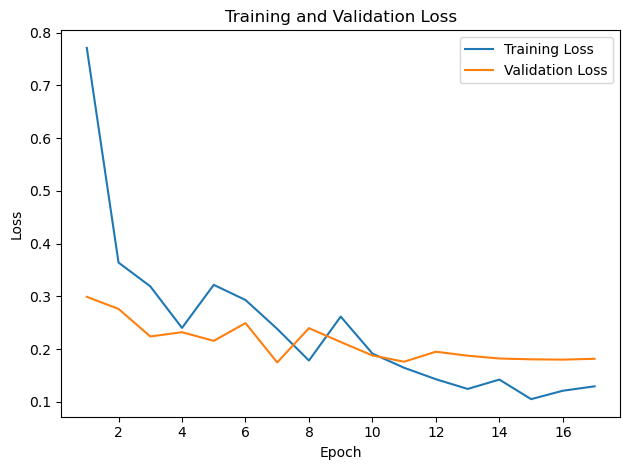

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224  # Adjust the image size based on DenseNet's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix DenseNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()